## Importing and prepping data

In [1]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca

In [2]:
features = []
remote_folder = '09_26_18_tissue_study' #Folder in AWS S3 containing files to be analyzed
bucket = 'hpontes.data'
vids = 5
types = ['10K', '1K', '5K', 'COOH']
slices = [1, 2, 3]
nonnum = ['Surface Functionality', 'Slice', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']

counter = 0
for typ in types:
    for slic in slices:
        for num in range(1, vids+1):
            filename = 'features_{}_tissue_S{}_XY{}.csv'.format(typ, slic, num)
            print(filename)
            aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
            fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
            print('{} size: {}'.format(filename, fstats.shape))
            fstats['Surface Functionality'] = pd.Series(fstats.shape[0]*[typ], index=fstats.index)
            fstats['Slice'] = pd.Series(fstats.shape[0]*[slic], index=fstats.index)
            fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
            counter = counter + 1
            if counter == 1:
                fstats_tot = fstats
            else:
                fstats_tot = fstats_tot.append(fstats, ignore_index=True)

features_10K_tissue_S1_XY1.csv
features_10K_tissue_S1_XY1.csv size: (2122, 67)
features_10K_tissue_S1_XY2.csv
features_10K_tissue_S1_XY2.csv size: (797, 67)
features_10K_tissue_S1_XY3.csv
features_10K_tissue_S1_XY3.csv size: (1611, 67)
features_10K_tissue_S1_XY4.csv
features_10K_tissue_S1_XY4.csv size: (2575, 67)
features_10K_tissue_S1_XY5.csv
features_10K_tissue_S1_XY5.csv size: (1523, 67)
features_10K_tissue_S2_XY1.csv
features_10K_tissue_S2_XY1.csv size: (2762, 67)
features_10K_tissue_S2_XY2.csv
features_10K_tissue_S2_XY2.csv size: (3170, 67)
features_10K_tissue_S2_XY3.csv
features_10K_tissue_S2_XY3.csv size: (1356, 67)
features_10K_tissue_S2_XY4.csv
features_10K_tissue_S2_XY4.csv size: (1783, 67)
features_10K_tissue_S2_XY5.csv
features_10K_tissue_S2_XY5.csv size: (1474, 67)
features_10K_tissue_S3_XY1.csv
features_10K_tissue_S3_XY1.csv size: (2013, 67)
features_10K_tissue_S3_XY2.csv
features_10K_tissue_S3_XY2.csv size: (1212, 67)
features_10K_tissue_S3_XY3.csv
features_10K_tissue_S3

In [ ]:
fstats_tot.to_csv('features.csv')

In [ ]:
#PCA analyses with too many datapoints fail. You get rows with lots of NAs. I'm going to try making a subset of the data first
#and then do a PCA analysis on that.

#include all in analysis
import random
subset = np.sort(np.array(random.sample(range(fstats_tot.shape[0]), 500000)))
fstats_sub = fstats_tot.loc[subset, :].reset_index(drop=True)

In [7]:
for typ in types:
    fstats_type = fstats_tot[fstats_tot['Surface Functionality']==typ].reset_index(drop=True)
    print(fstats_type.shape)

(25816, 70)
(100075, 70)
(25153, 70)
(60414, 70)


In [3]:
#with equal sample sizes for each particle type
import random
counter = 0
for typ in types:
    fstats_type = fstats_tot[fstats_tot['Surface Functionality']==typ].reset_index(drop=True)
    print(fstats_type.shape)
    subset = np.sort(np.array(random.sample(range(fstats_type.shape[0]), 25000)))
    if counter == 0:
        fstats_sub = fstats_type.loc[subset, :].reset_index(drop=True)
    else:
        fstats_sub = fstats_sub.append(fstats_type.loc[subset, :].reset_index(drop=True), ignore_index=True)
    counter = counter + 1

(25816, 70)
(100075, 70)
(25153, 70)
(60414, 70)


In [4]:
#fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
nonnum = ['Surface Functionality', 'Slice', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']

fstats_num = fstats_sub.drop(nonnum, axis=1)
fstats_raw = fstats_num.as_matrix()
#fstats

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [5]:
ncomp = 14
pcadataset = pca.pca_analysis(fstats_tot, dropcols=nonnum, n_components=ncomp)

Cumulative explained variance:
0 component: 0.25505836765383516
1 component: 0.38054624433792006
2 component: 0.4600060005013489
3 component: 0.5199759647687032
4 component: 0.5760959457552608
5 component: 0.6149655845789469
6 component: 0.6474829841452949
7 component: 0.6761293855784554
8 component: 0.7012234482337448
9 component: 0.7244565613122979
10 component: 0.7453394671927799
11 component: 0.7652307824220658
12 component: 0.7834031565387989
13 component: 0.800317102003612


In [13]:
pcadataset.components.to_csv('components.csv')

In [14]:
pcadataset.prcomps

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Mean Deff1,Std efficiency,asymmetry2,Std asymmetry2,Mean asymmetry1,trappedness,straightness,trappedness,Std MSD_ratio,Std kurtosis,Std MSD_ratio,D_fit,kurtosis,Std AR
1,Std frames,Std straightness,asymmetry3,Std asymmetry1,Mean asymmetry2,boundedness,efficiency,boundedness,Mean MSD_ratio,Mean kurtosis,Mean MSD_ratio,kurtosis,Std AR,kurtosis
2,Mean D_fit,Mean efficiency,asymmetry1,Std elongation,Std asymmetry1,alpha,frames,Mean boundedness,SN_Ratio,Std boundedness,Mean Deff2,alpha,Deff2,Deff2
3,Std fractal_dim,Mean alpha,elongation,Std trappedness,Std asymmetry2,D_fit,boundedness,Mean trappedness,Mean SN_Ratio,Std trappedness,Std Deff2,Std Deff2,frames,Std MSD_ratio
4,Mean elongation,Mean trappedness,Mean Quality,Std boundedness,Mean asymmetry3,MSD_ratio,trappedness,Std boundedness,Mean AR,kurtosis,Mean frames,Mean Deff2,fractal_dim,D_fit


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [6]:
kmostat = pca.kmo(pcadataset.scaled)

0.904069645383


In [ ]:
import scipy.stats as stat
stat.bartlett(pcadataset.scaled[0, :], pcadataset.scaled[1, :], pcadataset.scaled[2, :], pcadataset.scaled[3, :])

In [ ]:
newstr = ''
for i in range(pcadataset.scaled.shape[0]-1):
    newstr = newstr + 'pcadataset.scaled[{}, :], '.format(i)

newstr = 'stat.bartlett(' + newstr + 'pcadataset.scaled[{}, :])'.format(i+1)

In [ ]:
test = eval(newstr)

In [ ]:
test

## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [15]:
import numpy as np
ncomp = 14
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pcadataset.final[pcadataset.final['Surface Functionality']=='10K'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pcadataset.final[pcadataset.final['Surface Functionality']=='5K'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pcadataset.final[pcadataset.final['Surface Functionality']=='1K'].values[:, -ncomp:], axis=0)
dicti[3] = np.nanmean(pcadataset.final[pcadataset.final['Surface Functionality']=='COOH'].values[:, -ncomp:], axis=0)

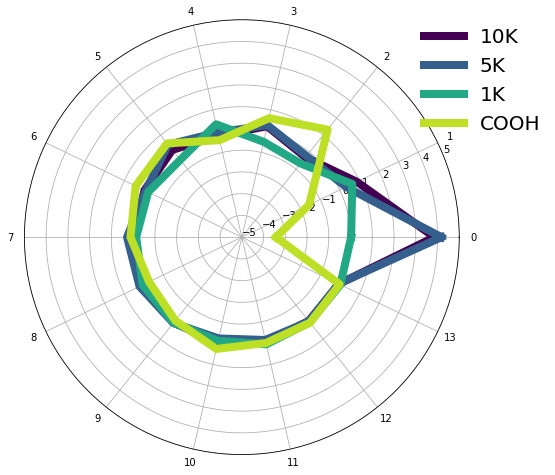

In [16]:
pca.plot_pca(dicti, savefig=True, labels=['10K', '5K', '1K', 'COOH'], rticks=np.linspace(-5, 5, 11))

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [ ]:
pcadataset.prcomps

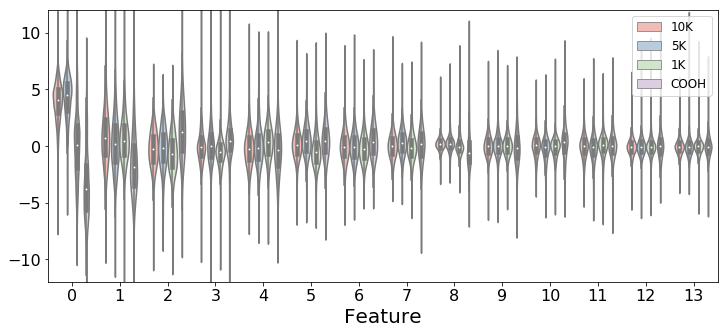

In [17]:
labels=['10K', '5K', '1K', 'COOH']
feats = pca.feature_violin(pcadataset.final, label='Surface Functionality', lvals=labels, fsubset=ncomp, yrange=[-12, 12])

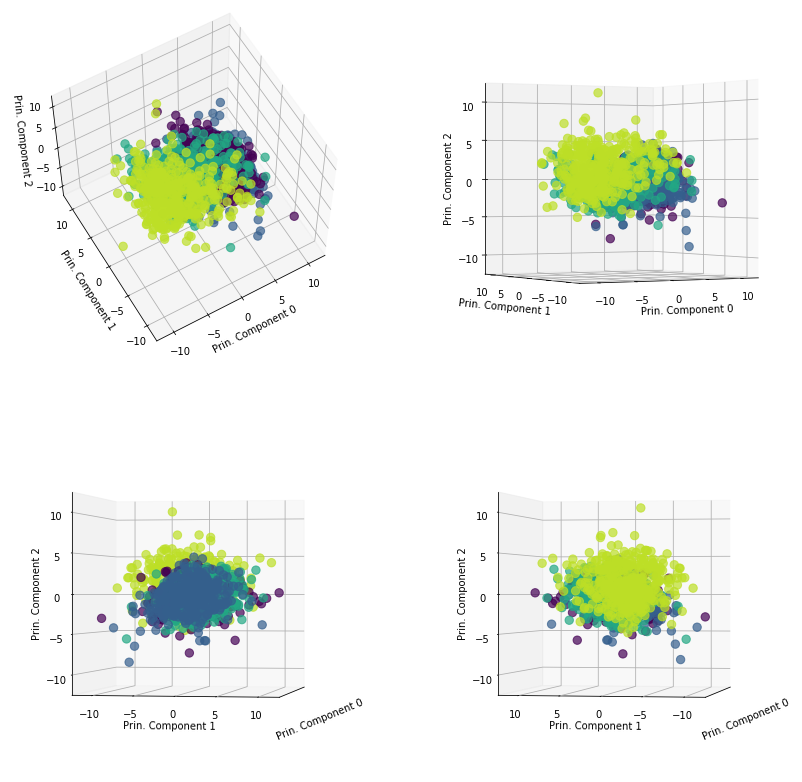

In [18]:
fstats1 = pca.feature_plot_3D(pcadataset.final, label='Surface Functionality', lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12])

In [19]:
#ncomp = 14
trainp = np.array([])
testp = np.array([])

for i in range(0, 20):
    KNNmod, X, y = pca.build_model(pcadataset.final, 'Surface Functionality', labels, equal_sampling=True,
                                       tsize=500, input_cols=ncomp, model='MLP', NNhidden_layer=(6, 2))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final['Surface Functionality'].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

Run 0: 0.7602502624634679
Run 1: 0.7530053249345023
Run 2: 0.7658400249694974
Run 3: 0.7722715622014774
Run 4: 0.7721675226286071
Run 5: 0.7544004010252627
Run 6: 0.7473966461424963
Run 7: 0.7597347936706107
Run 8: 0.7734727463609795
Run 9: 0.7549111407466258
Run 10: 0.7566656262709379
Run 11: 0.7584390280812265
Run 12: 0.7579519337173339
Run 13: 0.7532985273671368
Run 14: 0.7626951924259191
Run 15: 0.7631255379318824
Run 16: 0.754688874386403
Run 17: 0.7594132168090117
Run 18: 0.7533363599390895
Run 19: 0.7625911528530488


In [20]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.7124250000000001 +/ 0.012176077981024935
0.7597827937462758 +/ 0.006847753701734043


In [ ]:
fstats_num

In [21]:
import diff_classifier.heatmaps as hm

Plotted 1K_tissue_S1_XY1 trajectories successfully.


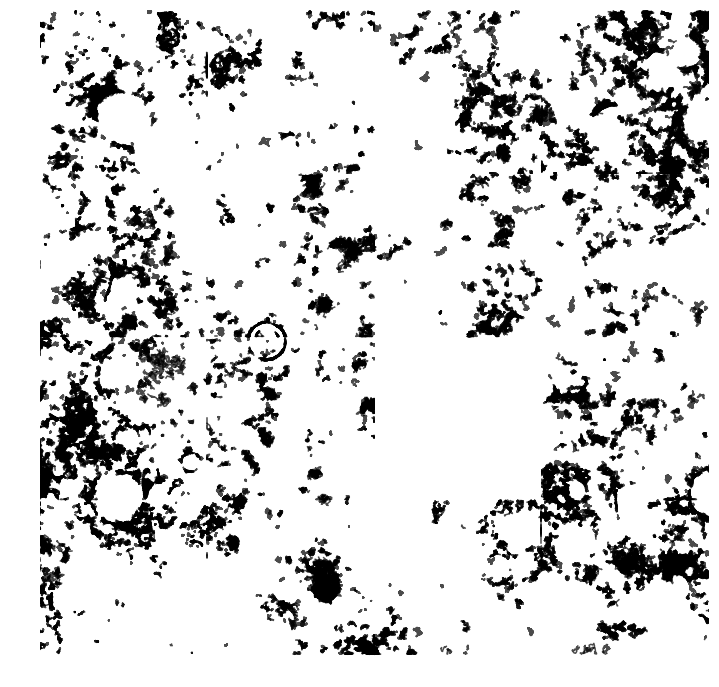

In [25]:
to_track = []
for typ in types:
    for slic in slices:
        for num in range(1, vids+1):
            #to_track.append('100x_0_4_1_2_gel_{}_bulk_vid_{}'.format(vis, num))
            to_track.append('{}_tissue_S{}_XY{}'.format(typ, slic, num))

hm.plot_trajectories(to_track[15], upload=False, remote_folder=remote_folder, bucket=bucket)

In [26]:
to_track[0]

'10K_tissue_S1_XY1'

Plotted 5K_tissue_S1_XY1 trajectories successfully.


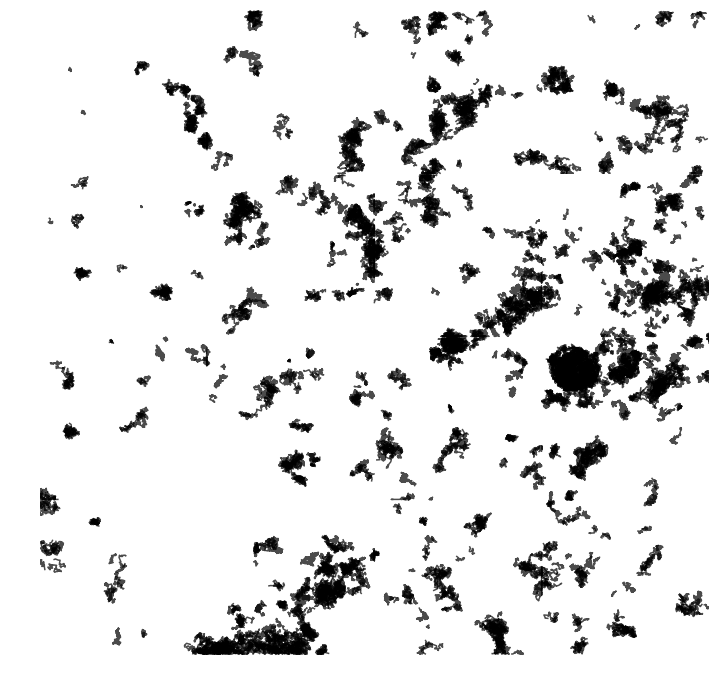

In [27]:
hm.plot_trajectories(to_track[30], upload=False, remote_folder=remote_folder, bucket=bucket)

Plotted COOH_tissue_S1_XY1 trajectories successfully.


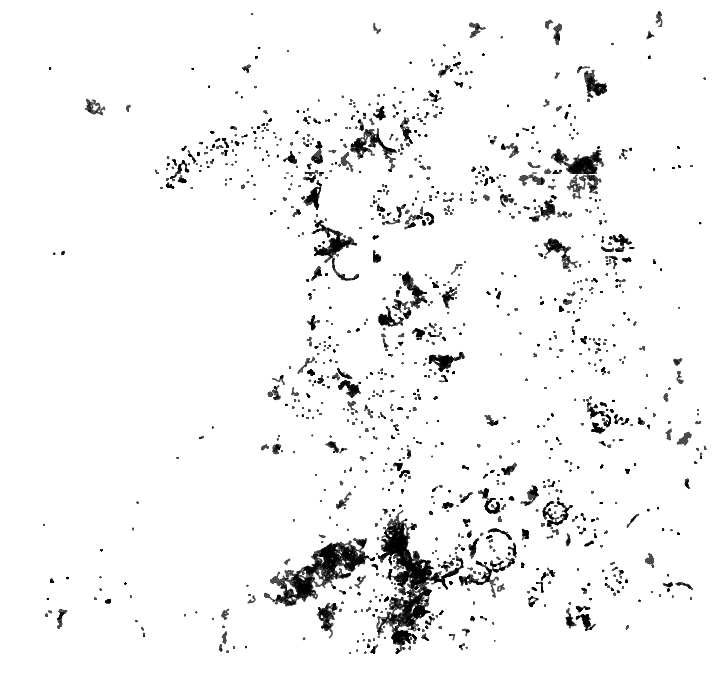

In [30]:
hm.plot_trajectories(to_track[45], upload=False, remote_folder=remote_folder, bucket=bucket)

Plotted COOH_tissue_S1_XY2 trajectories successfully.


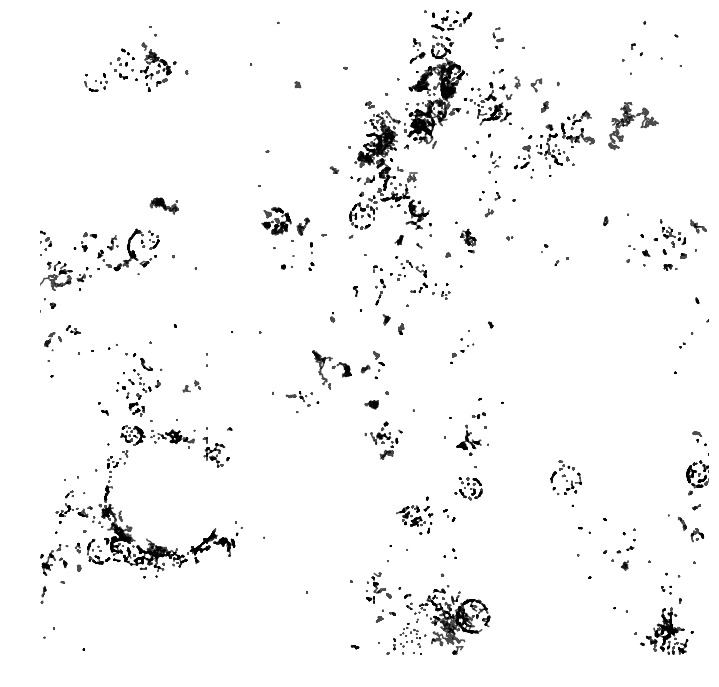

In [31]:
hm.plot_trajectories(to_track[46], upload=False, remote_folder=remote_folder, bucket=bucket)